In [1]:
import tkinter as tk
from tkinter import filedialog as fd
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import os

# import import_ipynb
# %run LESK32.ipynb

In [24]:
print(np.pi * 0.75 **2)

1.7671458676442586


C:\Users\lopezb41\AppData\Local\Temp\ipykernel_2008\2234492387.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df['Cycles'], np.random.rand(len(df)), c=colors, cmap=cmap, label='Data Points')


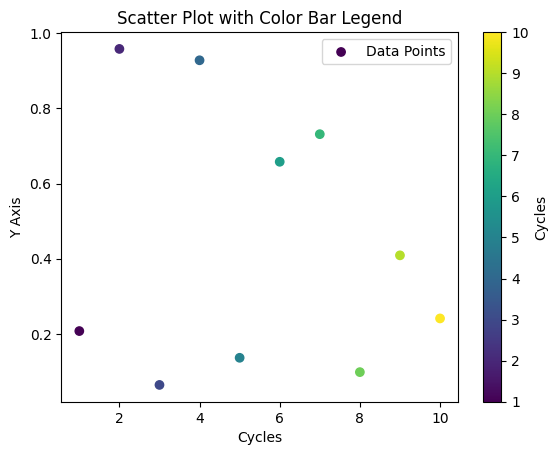

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pandas as pd

# Sample DataFrame with 'Cycles' column ranging from 1 to 10
data = {'Cycles': np.arange(1, 11)}
df = pd.DataFrame(data)

# Define the colormap and normalize based on the 'Cycles' values
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=df['Cycles'].min(), vmax=df['Cycles'].max())
colors = cmap(norm(df['Cycles']))

# Create a scatter plot with color-mapped points
plt.scatter(df['Cycles'], np.random.rand(len(df)), c=colors, cmap=cmap, label='Data Points')

# Create a color bar legend
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # An empty array is required for the ScalarMappable
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical')
cbar.set_label('Cycles')

# Customize the plot and add labels
plt.xlabel('Cycles')
plt.ylabel('Y Axis')  # You can modify this label based on your data
plt.title('Scatter Plot with Color Bar Legend')
plt.legend()

# Show the plot
plt.show()




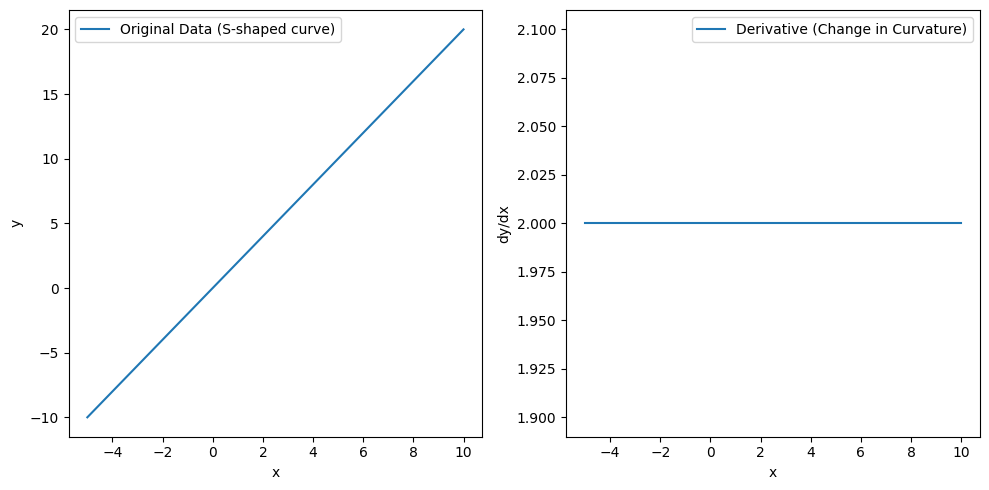

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have your data in x and y
# Replace this with your actual data
x = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = x*2   # S-shaped curve

# Calculate the derivative using numpy's gradient function
dy_dx = np.gradient(y, x)

# Plot the original data and the derivative
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, y, label='Original Data (S-shaped curve)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, dy_dx , label='Derivative (Change in Curvature)')
plt.xlabel('x')
plt.ylabel('dy/dx')
plt.legend()

plt.tight_layout()
plt.show()


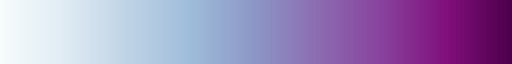

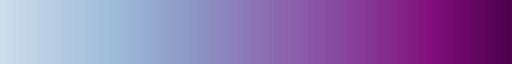

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Get the 'BuPu' colormap
BuPu = plt.cm.get_cmap('BuPu', 256)
display(BuPu)
# # Create a new colormap without the first 25 entries (which are close to white)
newcolors = BuPu(np.linspace(0, 1, 256))
newcmp = mcolors.LinearSegmentedColormap.from_list("BuPu_no_white", newcolors[50:,:])
newcmp
# # Display the new colormap
# gradient = np.linspace(0, 1, 256)
# gradient = np.vstack((gradient, gradient))

# fig, ax = plt.subplots()
# ax.imshow(gradient, aspect='auto', cmap=newcmp)
# plt.show()


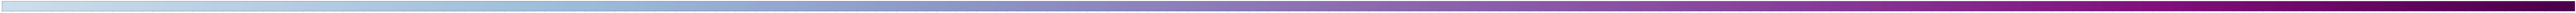

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Get the BuPu colormap
BuPu = plt.cm.get_cmap('BuPu', 256)

# Create a new colormap without the first 50 colors (which are close to white)
new_BuPu = ListedColormap(BuPu(np.linspace(0.2, 1, 256)))

# Now you can use new_BuPu as your colormap in seaborn
sns.palplot(sns.color_palette(new_BuPu.colors))

In [3]:
a = 4e-5 / 3.1416
print(a)

1.2732365673542146e-05


In [62]:
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Electrochemical\L22\L22_TiO2_90\1C\lith'
files = [os.path.join(path, i) for i in os.listdir(path)]
new_files = []
for i in files:
    directory, filename = os.path.split(i)
    numeric_part = filename.split('_')[-1].split('.txt')[0]
    numeric_two_decimals = '{:02d}'.format(int(numeric_part))
    
    new_filename =filename[:-7] + filename[-7:-4].replace(numeric_part, numeric_two_decimals) + '.txt'  # filename.replace(numeric_part, numeric_two_decimals)
    new_file_path = os.path.join(directory, new_filename)
    
    if i != new_file_path:
                
        os.rename(i, new_file_path)
        print(f"Renamed: {i} => {new_file_path}")

    

['C:\\Users\\lopezb41\\OneDrive - imec\\Documents\\Experiments\\Data\\Electrochemical\\L22\\L22_TiO2_90\\1C\\lith\\L22_TiO2_90_1C_lith_1C_01.txt',
 'C:\\Users\\lopezb41\\OneDrive - imec\\Documents\\Experiments\\Data\\Electrochemical\\L22\\L22_TiO2_90\\1C\\lith\\L22_TiO2_90_1C_lith_1C_02.txt',
 'C:\\Users\\lopezb41\\OneDrive - imec\\Documents\\Experiments\\Data\\Electrochemical\\L22\\L22_TiO2_90\\1C\\lith\\L22_TiO2_90_1C_lith_1C_03.txt',
 'C:\\Users\\lopezb41\\OneDrive - imec\\Documents\\Experiments\\Data\\Electrochemical\\L22\\L22_TiO2_90\\1C\\lith\\L22_TiO2_90_1C_lith_1C_04.txt',
 'C:\\Users\\lopezb41\\OneDrive - imec\\Documents\\Experiments\\Data\\Electrochemical\\L22\\L22_TiO2_90\\1C\\lith\\L22_TiO2_90_1C_lith_1C_05.txt',
 'C:\\Users\\lopezb41\\OneDrive - imec\\Documents\\Experiments\\Data\\Electrochemical\\L22\\L22_TiO2_90\\1C\\lith\\L22_TiO2_90_1C_lith_1C_06.txt',
 'C:\\Users\\lopezb41\\OneDrive - imec\\Documents\\Experiments\\Data\\Electrochemical\\L22\\L22_TiO2_90\\1C\\lith\\L22

In [8]:
#warburg
zw = 400.75
tau = 18.303
alpha = 0.69

print(34 * 9e-5)
print((16+7) * 0.035)

0.0030600000000000002
0.805


In [8]:
# Change txt file
file = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA3_TLM\Pt on top\AUT\S10_up.txt'
df = pd.read_csv(file, sep = ';', usecols=[0,1,2])
new_df = pd.concat([df['Potential applied (V)'], df['WE(1).Current (A)'], df['Time (s)']], axis = 1)

new_df.to_csv(r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA3_TLM\Pt on top\AUT\S10_up_new.txt', ';', index = False)

In [4]:
diameter = 1.5 # cm
radius = diameter / 2
area = np.pi * radius**2
print(0.05/area)
area

0.02829421210522584


1.7671458676442586

In [2]:
r = 1.5/2
area = np.pi * r**2
area

1.7671458676442586

In [3]:
a = 200 / 0.785
b = 10 / 3.1416
print(a,b)

254.77707006369425 3.183091418385536


In [4]:
areal_density = 90e15 # at/cm2 of Li
thickness_th = 68e-7 # cm ; 68 nm
li_density = areal_density * thickness_th
avo = 6.022e23 # 1/mol
li_mol = li_density / avo
print(li_mol * 1000)
print(100 * 100)

1.0162736632348058e-09
10000
